
# Kompletny przykład sztucznej sieci neuronowej – **KLASYFIKACJA**

W poprzedniej sekcji korzystaliśmy z czterech zmiennych ciągłych (długości), aby przeprowadzić klasyfikację.  

Teraz połączymy dane **ciągłe** i **kategoryczne**, by wykonać podobną klasyfikację.  

Celem jest oszacowanie, czy **przejazd taksówką w Nowym Jorku kosztuje mniej czy więcej niż 10 dolarów**, na podstawie kilku zmiennych wejściowych. 

Inspiracją do tego ćwiczenia jest [konkurs na Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).

<div class="alert alert-success">
<strong>UWAGA:</strong>  
Ten notatnik różni się od poprzedniego notatnika regresyjnego tym, że dla zbioru <tt><strong>y</strong></tt> używamy kolumny <tt>'fare_class'</tt>.  
Wyjście ma **dwie wartości zamiast jednej**.  
W tym zadaniu uczymy **model klasyfikacji binarnej** – przewiduje, czy kurs kosztuje **poniżej** czy **powyżej** 10 dolarów.
</div>

---

## Praca z danymi tabelarycznymi

Uczenie głębokie z sieciami neuronowymi często kojarzy się z zaawansowanym rozpoznawaniem obrazów.  
W kolejnych rozdziałach będziemy trenować modele analizujące piksele, wzorce i kolory.

Tym razem pracujemy z **danymi tabelarycznymi** (arkusze kalkulacyjne, tabele SQL itp.), w których kolumny mogą – ale nie muszą – być istotne.  

Sieci neuronowe potrafią odkrywać zależności, na które sami byśmy nie wpadli.  
Aby to było możliwe, musimy traktować zmienne **kategoryczne** inaczej niż **ciągłe**.

---

### Kluczowe zagadnienia

- **wartości ciągłe vs. kategoryczne**  
- **embeddings**  
- **batch normalization**  
- **warstwy dropout**
```

Chcesz, żebym też zamienił ten `<div class="alert ...">` na czysto-markdownowy blok typu > **UWAGA:**, żeby było w 100% zgodne z Markdownem, czy zostawić w wersji HTML (tak jak masz teraz)?


## Wykonaj standardowe importy


In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Wczytaj zbiór NYC Taxi Fares
<a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Konkurs Kaggle</a> udostępnia zbiór około 55 milionów rekordów. Dane obejmują wyłącznie datę i godzinę rozpoczęcia kursu, współrzędne GPS miejsca startu i zakończenia oraz liczbę pasażerów. To uczestnik konkursu decyduje, jakie dodatkowe informacje wydobyć. Czy pora dnia ma znaczenie? Dzień tygodnia? Jak wyliczyć odległość na podstawie par współrzędnych GPS?

Na potrzeby ćwiczenia ograniczyliśmy zbiór do 120 000 rekordów z okresu 11–24 kwietnia 2010 r. Rekordy są losowo posortowane. Pokażemy, jak obliczyć odległość ze współrzędnych GPS oraz jak stworzyć obiekt datetime z kolumny tekstowej. Dzięki temu szybko uzyskamy informacje takie jak dzień tygodnia czy podział na AM/PM.

Zaczynajmy!


In [2]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_class'].value_counts()

fare_class
0    80000
1    40000
Name: count, dtype: int64

Wygodnie, bo 2/3 danych zawiera kursy tańsze niż \$10, a 1/3 droższe lub równe \$10.


Klasy odpowiadają kwotom przejazdu następująco:
<table style="display: inline-block">
<tr><th>Klasa</th><th>Wartości</th></tr>
<tr><td>0</td><td>< \$10.00</td></tr>
<tr><td>1</td><td>>= \$10.00</td></tr>
</table>


## Oblicz przejechaną odległość
<a href='https://en.wikipedia.org/wiki/Haversine_formula'>Wzór haversine</a> wyznacza odległość na kuli pomiędzy dwiema parami współrzędnych GPS.<br>
Szerokość geograficzną oznaczymy przez $\varphi$ (phi), a długość przez $\lambda$ (lambda).

Wzór przyjmuje postać

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

przy czym

$\begin{split} r&: \text{promień kuli (średni promień Ziemi to 6371 km)}\\
\varphi_1, \varphi_2&: \text{szerokości geograficzne punktów 1 i 2}\\
\lambda_1, \lambda_2&: \text{długości geograficzne punktów 1 i 2}\end{split}$


In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # średni promień Ziemi w kilometrach
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # w kilometrach

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


## Dodaj kolumnę datetime i wyprowadź przydatne statystyki
Tworząc obiekt datetime, możemy wydobyć informacje takie jak „dzień tygodnia” czy „przed południem / po południu”. Zwróć uwagę, że dane zapisano w czasie UTC. Nasz zakres obejmuje kwiecień 2010 r., czyli okres obowiązywania czasu letniego w Nowym Jorku. Dlatego przeliczymy czas na EDT, odejmując cztery godziny (UTC-4).


In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Oddziel kolumny kategoryczne od ciągłych


In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_class']  # ta kolumna zawiera etykiety

<div class="alert alert-info"><strong>UWAGA:</strong> Jeśli planujesz wykorzystać wszystkie kolumny z tabeli, możesz w prosty sposób pobrać pozostałe kolumny ciągłe:<br>
<pre style='background-color:rgb(217,237,247)'>cont_cols = [col for col in df.columns if col not in cat_cols + y_col]</pre>

Tutaj wpisaliśmy kolumny ciągłe ręcznie, ponieważ pomijamy te, które nie trafią do modelu (fare_amount i EDTdate).</div>


## Zamiana na typ category
Pandas udostępnia typ danych <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category</strong></a>, który zamienia wartości kategoryczne na kody liczbowe. Zbiór zawierający miesiące roku otrzyma 12 kodów, po jednym na każdy miesiąc (zwykle od 0 do 11). Pandas zastępuje wartości w kolumnie kodami i przechowuje listę kategorii. W kolejnych krokach będziemy odwoływać się do „nazw” kategorii i przypisanych im „kodów”.


In [11]:
# Zamień trzy kolumny kategoryczne na typ category.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

Możemy sprawdzić, że <tt>df['Hour']</tt> to cecha kategoryczna, wyświetlając kilka wierszy:


In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Widzimy, że nazwami kategorii są tutaj liczby całkowite od 0 do 23, czyli 24 unikalne wartości. Te liczby <em>również</em> odpowiadają kodom nadanym każdej nazwie.

Do nazw kategorii odwołujemy się przez <tt>Series.cat.categories</tt>, a do samych kodów przez <tt>Series.cat.codes</tt>. Łatwiej to zrozumieć na przykładzie <tt>df['AMorPM']</tt>:


In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): ['am', 'pm']

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>UWAGA:</strong> W danych kategorycznych wartości NaN otrzymują kod -1. W tym zbiorze takich wartości nie ma.</div>


Teraz chcemy połączyć trzy kolumny kategoryczne w jedną tablicę wejściową przy użyciu <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a>. Interesują nas wyłącznie wartości, bez indeksu Series.


In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>UWAGA:</strong> Można to zrobić w jednej linii z użyciem list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Nie przejmujemy się na razie typem danych – ustawimy <tt>int64</tt>, gdy będziemy tworzyć tensor.</div>


## Konwersja tablic NumPy na tensory


In [20]:
# Przekonwertuj zmienne kategoryczne na tensor
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

Możemy przekazać wszystkie zmienne ciągłe do modelu jako tensor. Zauważ, że nie normalizujemy ich teraz – pozwolimy zrobić to modelowi.
<div class="alert alert-info"><strong>UWAGA:</strong> Aby batch normalization działał poprawnie, musimy zapisać <tt>conts</tt> i <tt>y</tt> jako tensory typu Float (float32), a nie Double (float64).</div>


In [21]:
# Przekonwertuj zmienne ciągłe na tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

Uwaga: funkcja CrossEntropyLoss, której użyjemy później, oczekuje tensorów y w postaci 1D. Zamiast <tt>.reshape(-1,1)</tt> użyjemy więc tym razem <tt>.flatten()</tt>.


In [23]:
# Przekonwertuj etykiety na tensor
y = torch.tensor(df[y_col].values).flatten()

y[:5]

tensor([0, 0, 1, 0, 1])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000])

## Ustal rozmiary embeddingów


In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Zdefiniuj TabularModel
Model nawiązuje nieco do <a href='https://docs.fast.ai/tabular.models.html'>biblioteki fast.ai</a>. Chcemy zdefiniować architekturę na podstawie liczby kolumn ciągłych (<tt>conts.shape[1]</tt>) oraz liczby kolumn kategorycznych i ich embeddingów (<tt>len(emb_szs)</tt> i <tt>emb_szs</tt>). Wyjściem może być regresja (pojedyncza wartość zmiennoprzecinkowa) albo klasyfikacja (zestaw klas i ich wartości softmax). W tym ćwiczeniu wyjście będzie dwuelementowym wektorem – po jednej wartości dla każdej klasy. Założymy, że dane zawierają zarówno cechy kategoryczne, jak i ciągłe. We własnych klasach możesz dodać parametry boolowskie, aby obsługiwać inne przypadki.


In [ ]:
import torch
import torch.nn as nn

class TabularModel(nn.Module):
    """
    Model sieci neuronowej do danych tabelarycznych łączący:
    - embeddingi dla zmiennych kategorycznych,
    - normalizację i gęste warstwy dla zmiennych ciągłych.

    Założenia / Konwencje:
    - Każda kolumna kategoryczna jest reprezentowana jako indeks całkowity (torch.long)
      w zakresie [0, liczba_kategorii-1]. To bardzo ważne dla nn.Embedding.
    - Zmienne ciągłe są typu float (torch.float) i mają kształt [batch_size, n_cont].
    - Wyjście to logity o kształcie [batch_size, out_sz]; do klasyfikacji z CrossEntropyLoss.

    Parametry
    ---------
    emb_szs : list[tuple[int, int]]
        Lista krotek (liczba_kategorii, wymiar_embeddingu) dla każdej kolumny kategorycznej.
        Np. [(2, 2), (14, 6), (6, 3), (5, 3), (12, 6)].
        Uwaga: indeksy wejściowe MUSZĄ być 0-based i < liczba_kategorii.
    n_cont : int
        Liczba zmiennych ciągłych (kolumn numerycznych).
    out_sz : int
        Rozmiar wyjścia modelu (np. liczba klas).
    layers : list[int]
        Rozmiary kolejnych ukrytych warstw liniowych (np. [200, 100]).
    p : float, domyślnie 0.5
        Prawdopodobieństwo dropout (stosowane zarówno na embeddingach, jak i w warstwach gęstych).

    Przepływ danych
    ---------------
    x_cat (LongTensor) -> Embedding -> konkatenacja -> Dropout
                         + x_cont (FloatTensor) -> BatchNorm -> konkatenacja
                         -> bloki Linear/ReLU/BatchNorm/Dropout -> Linear -> logity

    Przykład wejścia
    ----------------
    x_cat : torch.LongTensor o kształcie [B, K] (B — batch, K — liczba kolumn kategorycznych)
    x_cont: torch.FloatTensor o kształcie [B, n_cont]
    """

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()

        # Embeddingi dla każdej kolumny kategorycznej.
        # Dla (ni, nf): ni = liczba kategorii, nf = wymiar wektora embeddingu.
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])

        # Dropout na połączonych embeddingach pomaga zapobiegać przeuczeniu (overfitting).
        self.emb_drop = nn.Dropout(p)

        # Normalizacja zmiennych ciągłych stabilizuje trening (uśrednia/standaryzuje aktywacje).
        self.bn_cont = nn.BatchNorm1d(n_cont)

        # Obliczamy łączny wymiar embeddingów i wejścia do pierwszej warstwy gęstej.
        n_emb = sum(nf for _, nf in emb_szs)  # suma wymiarów wszystkich embeddingów
        n_in = n_emb + n_cont                 # embeddingi + zmienne ciągłe

        # Budujemy sekwencję bloków: Linear -> ReLU -> BatchNorm -> Dropout
        layerlist = []
        for hidden_size in layers:
            layerlist.append(nn.Linear(n_in, hidden_size))   # projekcja do ukrytej przestrzeni
            layerlist.append(nn.ReLU(inplace=True))          # nieliniowość (szybka i stabilna)
            layerlist.append(nn.BatchNorm1d(hidden_size))    # stabilizacja rozkładu aktywacji
            layerlist.append(nn.Dropout(p))                  # regularizacja
            n_in = hidden_size

        # Ostatnia warstwa liniowa do rozmiaru wyjścia (np. liczba klas).
        layerlist.append(nn.Linear(layers[-1], out_sz))

        # Łączymy wszystko w jedną sekwencję wykonywalnych modułów.
        self.layers = nn.Sequential(*layerlist)

    def forward(self, x_cat: torch.Tensor, x_cont: torch.Tensor) -> torch.Tensor:
        """
        Wykonuje propagację w przód.

        Parametry
        ---------
        x_cat : torch.LongTensor, kształt [B, K]
            Indeksy kategorii (0-based) dla K kolumn kategorycznych. Każda kolumna musi
            mieć wartości < liczba_kategorii zdefiniowana w `emb_szs`.
        x_cont : torch.FloatTensor, kształt [B, n_cont]
            Zmienne ciągłe (numeryczne).

        Zwraca
        -------
        torch.Tensor
            Logity o kształcie [B, out_sz] — surowe wyniki do użycia z CrossEntropyLoss.
        """
        # 1) Embedding dla każdej kolumny kategorycznej; dostajemy listę [B, nf_i]
        embeddings = []
        for i, emb in enumerate(self.embeds):
            # x_cat[:, i] to wektor indeksów dla i-tej kolumny (kształt: [B])
            embeddings.append(emb(x_cat[:, i]))

        # 2) Konkatenacja wszystkich embeddingów do jednego tensora [B, sum(nf)]
        x = torch.cat(embeddings, dim=1)

        # 3) Dropout na embeddingach (regularizacja)
        x = self.emb_drop(x)

        # 4) Normalizacja zmiennych ciągłych i doklejenie ich do embeddingów
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], dim=1)

        # 5) Przepuszczenie przez zdefiniowane bloki gęste
        x = self.layers(x)
        return x


**ℹ️ Przejdźmy przez kroki, które wykonaliśmy. Poniżej znajdziesz bardziej szczegółowe informacje.**

---

1. **Rozszerzamy bazową klasę `Module` i przekazujemy parametry:**
   - `emb_szs`: lista krotek – liczba kategorii oraz rozmiar embeddingu dla każdej kolumny  
   - `n_cont`: liczba zmiennych ciągłych  
   - `out_sz`: rozmiar wyjścia  
   - `layers`: lista rozmiarów kolejnych warstw  
   - `p`: prawdopodobieństwo dropout (dla uproszczenia jedna wartość)  

   ```python
   class TabularModel(nn.Module):
       def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
           super().__init__()


2. **Tworzymy warstwy embeddingów** przy użyciu [`torch.nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) oraz [`torch.nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
   Dane kategoryczne przejdą przez te embeddingi w metodzie `forward`.

   ```python
   self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
   ```

3. **Dodajemy dropout** dla embeddingów za pomocą [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).
   Domyślnie `p = 0.5`.

   ```python
   self.emb_drop = nn.Dropout(p)
   ```

4. **Tworzymy funkcję normalizującą** dla zmiennych ciągłych z [`torch.nn.BatchNorm1d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html).

   ```python
   self.bn_cont = nn.BatchNorm1d(n_cont)
   ```

5. **Budujemy sekwencję warstw sieci:**
   `Linear → ReLU → BatchNorm → Dropout`
   Na końcu dodajemy warstwę wyjściową. Wszystko składamy w [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

   ```python
   layerlist = []
   n_emb = sum((nf for ni, nf in emb_szs))
   n_in = n_emb + n_cont

   for i in layers:
       layerlist.append(nn.Linear(n_in, i))
       layerlist.append(nn.ReLU(inplace=True))
       layerlist.append(nn.BatchNorm1d(i))
       layerlist.append(nn.Dropout(p))
       n_in = i

   layerlist.append(nn.Linear(layers[-1], out_sz))
   self.layers = nn.Sequential(*layerlist)
   ```

6. **Definiujemy metodę `forward`:**

   * najpierw przetwarzamy embeddingi
   * następnie normalizujemy zmienne ciągłe
   * na końcu przekazujemy dane przez warstwy

   Do łączenia tensorów używamy [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html).

   ```python
   def forward(self, x_cat, x_cont):
       embeddings = []
       for i, e in enumerate(self.embeds):
           embeddings.append(e(x_cat[:, i]))
       x = torch.cat(embeddings, 1)
       x = self.emb_drop(x)

       x_cont = self.bn_cont(x_cont)
       x = torch.cat([x, x_cont], 1)

       x = self.layers(x)
       return x
   ```



<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [28]:
# To nasze dane źródłowe
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [29]:
# To jest przekazywane podczas tworzenia instancji modelu
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [30]:
# To przypisanie wykonywane jest w metodzie __init__()
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [31]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [32]:
# To dzieje się wewnątrz metody forward()
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-0.7232, -0.7835,  0.7790, -1.0627, -1.5836,  1.2645, -1.3451,  0.1102,
          -0.6855,  1.0613,  0.4491, -0.2776],
         [ 0.7909, -0.1582,  0.1696, -0.6959,  1.5319,  0.4137, -1.3975,  0.7816,
          -0.2047, -1.3527, -0.0670, -1.7311],
         [ 1.1835,  0.0372, -0.1430,  1.3317, -0.8409,  2.3899,  0.7840, -0.8389,
           0.7472,  0.3831,  0.8816,  0.7843],
         [-0.5777,  0.4101, -0.6764,  0.4647, -0.6966, -0.7015, -0.8748, -1.4114,
           0.5709, -0.3537, -0.6927,  0.1717]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7280],
         [-0.7280],
         [-0.7280],
         [-0.7037]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.2462,  1.7763,  0.3319, -1.4416],
         [ 1.5747, -0.2930, -0.2527, -0.3491],
         [ 1.5747, -0.2930, -0.2527, -0.3491],
         [-0.6523,  0.5418, -1.2006, -0.3129]], grad_fn=<EmbeddingBackward0>)]

In [33]:
# Łączymy sekcje embeddingów (12,1,4) w jedną (17)
z = torch.cat(embeddingz, 1)
z

tensor([[-0.7232, -0.7835,  0.7790, -1.0627, -1.5836,  1.2645, -1.3451,  0.1102,
         -0.6855,  1.0613,  0.4491, -0.2776, -0.7280, -0.2462,  1.7763,  0.3319,
         -1.4416],
        [ 0.7909, -0.1582,  0.1696, -0.6959,  1.5319,  0.4137, -1.3975,  0.7816,
         -0.2047, -1.3527, -0.0670, -1.7311, -0.7280,  1.5747, -0.2930, -0.2527,
         -0.3491],
        [ 1.1835,  0.0372, -0.1430,  1.3317, -0.8409,  2.3899,  0.7840, -0.8389,
          0.7472,  0.3831,  0.8816,  0.7843, -0.7280,  1.5747, -0.2930, -0.2527,
         -0.3491],
        [-0.5777,  0.4101, -0.6764,  0.4647, -0.6966, -0.7015, -0.8748, -1.4114,
          0.5709, -0.3537, -0.6927,  0.1717, -0.7037, -0.6523,  0.5418, -1.2006,
         -0.3129]], grad_fn=<CatBackward0>)

In [34]:
# To zostało przypisane w metodzie __init__()
selfembdrop = nn.Dropout(.4)

In [35]:
z = selfembdrop(z)
z

tensor([[-1.2053, -1.3058,  1.2983, -1.7711, -2.6394,  2.1076, -2.2419,  0.1837,
         -1.1426,  1.7688,  0.0000, -0.4627, -0.0000, -0.0000,  2.9605,  0.0000,
         -2.4027],
        [ 1.3181, -0.0000,  0.2827, -0.0000,  0.0000,  0.6896, -2.3291,  1.3026,
         -0.3411, -2.2545, -0.0000, -2.8851, -0.0000,  2.6245, -0.4884, -0.4212,
         -0.0000],
        [ 1.9725,  0.0621, -0.0000,  2.2194, -1.4014,  3.9831,  1.3067, -0.0000,
          0.0000,  0.0000,  1.4693,  0.0000, -1.2133,  2.6245, -0.0000, -0.0000,
         -0.5818],
        [-0.0000,  0.6835, -0.0000,  0.0000, -0.0000, -1.1691, -1.4580, -0.0000,
          0.9515, -0.0000, -1.1545,  0.2861, -1.1728, -1.0871,  0.9029, -2.0010,
         -0.5215]], grad_fn=<MulBackward0>)

<div class="alert alert-danger"><strong>Tak przekazujemy embeddingi kategoryczne do kolejnych warstw.</strong></div>


In [37]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [38]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Zdefiniuj funkcję straty i optymalizator
W klasyfikacji zastąpimy funkcję MSE odpowiednikiem <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a>.<br>
Jako optymalizatora nadal użyjemy <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>.


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Podziel dane na zbiory treningowy i testowy
W tej chwili rozmiar partii odpowiada całemu zbiorowi 120 000 rekordów. Aby oszczędzić czas, wykorzystamy pierwsze 60 000. Pamiętaj, że nasze tensory są już losowo potasowane.


In [40]:
batch_size = 60000
test_size = 12000

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [41]:
len(cat_train)

48000

In [42]:
len(cat_test)

12000

## Wytrenuj model
Przygotuj się na około 30 minut pracy! Dodaliśmy kod, który na końcu poda czas trwania.


In [43]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # sprytny trik, żeby oszczędzić miejsce na ekranie:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # wypisz ostatnią linię
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # wypisz czas trwania

epoch:   1  loss: 0.83336741
epoch:  26  loss: 0.37834561
epoch:  51  loss: 0.33235851
epoch:  76  loss: 0.31583560
epoch: 101  loss: 0.30307907
epoch: 126  loss: 0.29316762
epoch: 151  loss: 0.28483155
epoch: 176  loss: 0.28016236
epoch: 201  loss: 0.27618173
epoch: 226  loss: 0.26887164
epoch: 251  loss: 0.26491734
epoch: 276  loss: 0.26132721
epoch: 300  loss: 0.25677466

Duration: 29 seconds


## Wykres funkcji straty


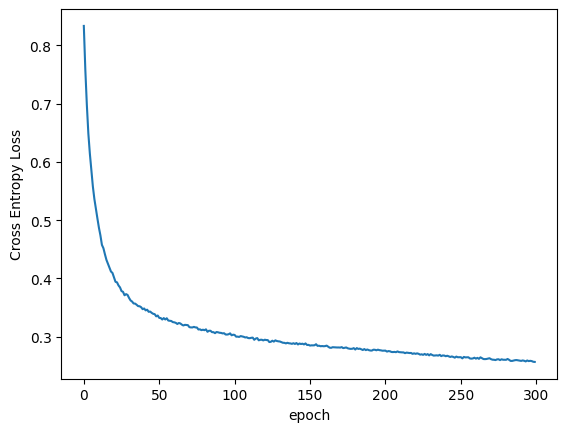

In [46]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

## Zweryfikuj model


In [47]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25060156


Spójrzmy teraz na pierwsze 50 przewidywanych wartości.


In [48]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.2166, -0.9363])    0      0   
tensor([-3.9228,  3.1928])    1      0   
tensor([ 2.1874, -1.1944])    0      0   
tensor([-1.6648,  0.9327])    1      1   
tensor([ 2.8884, -1.1588])    0      0   
tensor([ 1.1080, -2.1643])    0      0   
tensor([ 2.4007, -1.4130])    0      0   
tensor([-4.9656,  1.4911])    1      1   
tensor([ 1.0492, -3.0409])    0      0   
tensor([-1.2398,  1.3428])    1      1   
tensor([ 1.2044, -1.7862])    0      0   
tensor([ 3.0715, -0.9532])    0      0   
tensor([ 1.8248, -1.4403])    0      0   
tensor([-2.0106,  0.7805])    1      1   
tensor([ 1.7691, -2.1559])    0      0   
tensor([-3.5679,  1.1670])    1      1   
tensor([ 1.5308, -2.3760])    0      1   
tensor([ 1.7814, -2.1364])    0      0   
tensor([ 1.0488, -0.3051])    0      0   
tensor([ 2.2438, -1.7580])    0      0   
tensor([-2.7073,  0.2314])    1      1   
tensor([-1.4891,  0.5462])    1      1   
tensor([-2.0723,  0.4434])    1   

## Zapisz model
Zapisz wytrenowany model do pliku, aby w przyszłości móc zasilić go nowymi danymi.


In [49]:
# Pamiętaj, żeby zapisać model dopiero po zakończeniu treningu!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareClssModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

## Wczytanie zapisanego modelu (od zera)
Możemy wczytać wyuczone wagi i biasy z zapisanej wersji. Jeśli dopiero otworzyłeś notatnik, uruchom najpierw standardowe importy i definicje funkcji. Aby to zademonstrować, przed dalszą pracą zrestartuj kernel.


In [50]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Zdefiniujmy model. Zanim załadujemy zapisane ustawienia, musimy utworzyć TabularModel z tymi samymi parametrami co wcześniej (rozmiary embeddingów, liczba zmiennych ciągłych, rozmiar wyjścia, rozmiary warstw i wartość dropout).


In [51]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 2, [200,100], p=0.4)

Gdy model jest gotowy, załadowanie zapisanych ustawień to formalność.


In [52]:
model2.load_state_dict(torch.load('TaxiFareClssModel.pt'));
model2.eval() # koniecznie wykonaj ten krok!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

Zdefiniujemy teraz funkcję, która przyjmie nowe dane użytkownika, wykona wszystkie opisane wcześniej kroki przetwarzania i przekaże dane przez wytrenowany model.


In [53]:
def test_data(mdl): # przekaż nazwę nowego modelu
    # WPROWADŹ NOWE DANE
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PRZETWÓRZ DANE
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # Możemy pominąć krok .astype(category), bo pola są niewielkie,
    # i zakodować je od razu
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # UTWÓRZ TENSORY KAT I CONT
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PRZEPROWADŹ DANE PRZEZ MODEL BEZ WYKONYWANIA BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts).argmax().item()
    print(f'\nThe predicted fare class is {z}')

## Przepuść nowe dane przez wytrenowany model
Dla wygody poniżej znajdziesz wartości minimalne i maksymalne każdej zmiennej:
<table style="display: inline-block">
<tr><th>Kolumna</th><th>Minimum</th><th>Maksimum</th></tr>
<tr><td>pickup_latitude</td><td>40</td><td>41</td></tr>
<tr><td>pickup_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>dropoff_latitude</td><td>40</td><td>41</td></tr>
<tr><td>dropoff_longitude</td><td>-74.5</td><td>-73.3</td></tr>
<tr><td>passenger_count</td><td>1</td><td>5</td></tr>
<tr><td>EDTdate</td><td>2010-04-11 00:00:00</td><td>2010-04-24 23:59:42</td></tr>


<strong>Zachowaj ostrożność!</strong> Odległość odpowiadająca 1 stopniowi szerokości geograficznej (od 40 do 41) to 111 km (69 mil), a 1 stopniowi długości (od -73 do -74) – 85 km (53 mile). Najdłuższy kurs w zbiorze różnił się zaledwie o 0.243 stopnia szerokości i 0.284 stopnia długości. Średnia różnica dla obu wynosi ok. 0.02. Aby uzyskać wiarygodne prognozy, korzystaj z wartości położonych blisko siebie.


In [54]:
test_data(model2)

What is the pickup latitude?   40
What is the pickup longitude?  -74.5
What is the dropoff latitude?   41
What is the dropoff longitude?  -73
How many passengers?  2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS      2010-04-22 11:00:00



The predicted fare class is 1


/var/folders/ff/6wst9f1n1g96lc__ld426szh0000gn/T/ipykernel_36178/1854116044.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],


Świetnie! Poprzednia regresja przewidywała cenę około \$14, a klasyfikacja binarna słusznie ocenia, że kurs przekracza 10 dolarów.
## Świetna robota!
